In [102]:
"""
#I have a venv for jupiter_noteboks 
#and the jupiter kernel ia am using is installed in this venv
#lets activate it and install necessary packages
#!source .jupyter_venv/.venv/bin/activate # source venv, if you have one for your kernal
import sys

!{sys.executable} -m pip install pyhafas
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install pyarrow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn

"""

'\n#I have a venv for jupiter_noteboks \n#and the jupiter kernel ia am using is installed in this venv\n#lets activate it and install necessary packages\n#!source .jupyter_venv/.venv/bin/activate # source venv, if you have one for your kernal\nimport sys\n\n!{sys.executable} -m pip install pyhafas\n!{sys.executable} -m pip install pandas\n!{sys.executable} -m pip install pyarrow\n!{sys.executable} -m pip install matplotlib\n!{sys.executable} -m pip install seaborn\n\n'

In [103]:
# from pyhafas import HafasClient
#from pyhafas.profile import DBProfile
#from datetime import datetime, date, timedelta
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault
from matplotlib import rc
import matplotlib.dates as mplt_dates
import numpy as np

from scipy.stats import lognorm

## read data

In [104]:
data_path = r"data/2024-10-28 01:17:22.584441/result.feather"
# data_path = "data/2024-11-01/result.feather"
# November 01 data as a comparison, to check for outliers
df = pd.read_feather(data_path)

####################

In [105]:
'''
#speed analysis of vectorized filters:
%timeit df["platform"][df["platform"]<100] #1
%timeit df.loc[df["platform"]<100, "platform"]
%timeit df.loc[df["platform"]<100, ["platform"]]
#one is the fastest of them
'''

'\n#speed analysis of vectorized filters:\n%timeit df["platform"][df["platform"]<100] #1\n%timeit df.loc[df["platform"]<100, "platform"]\n%timeit df.loc[df["platform"]<100, ["platform"]]\n#one is the fastest of them\n'

In [106]:
'''
%%timeit
# a simple for loop is much much slower (not vectorized):
platform = df["platform"]
result=pd.Series(index=range(len(platform)))
for i in range(len(platform)):
    if platform.iat[i]<100:
        platform.iat[i]=platform.iat[i]
'''

'\n%%timeit\n# a simple for loop is much much slower (not vectorized):\nplatform = df["platform"]\nresult=pd.Series(index=range(len(platform)))\nfor i in range(len(platform)):\n    if platform.iat[i]<100:\n        platform.iat[i]=platform.iat[i]\n'

####################

## settings for plots

In [107]:
figure = {'figsize': (17,7)}
font = {'size' : 19} #set to 22 for presentation
axes = {'labelsize': 'large', 'titlesize': 'x-large'}
rc('figure', **figure)
rc('font', **font)
rc('axes', **axes)
seaborn_fontsize = 14

## tasks/ questions

### What are the rush hours of the day? (Departures, by time)

In [108]:
def format_date_xaxis():
    plt.xticks(rotation=45)
    xformatter = mplt_dates.DateFormatter('%H:%M')
    plt.gca().xaxis.set_major_formatter(xformatter)      

<Figure size 640x480 with 0 Axes>

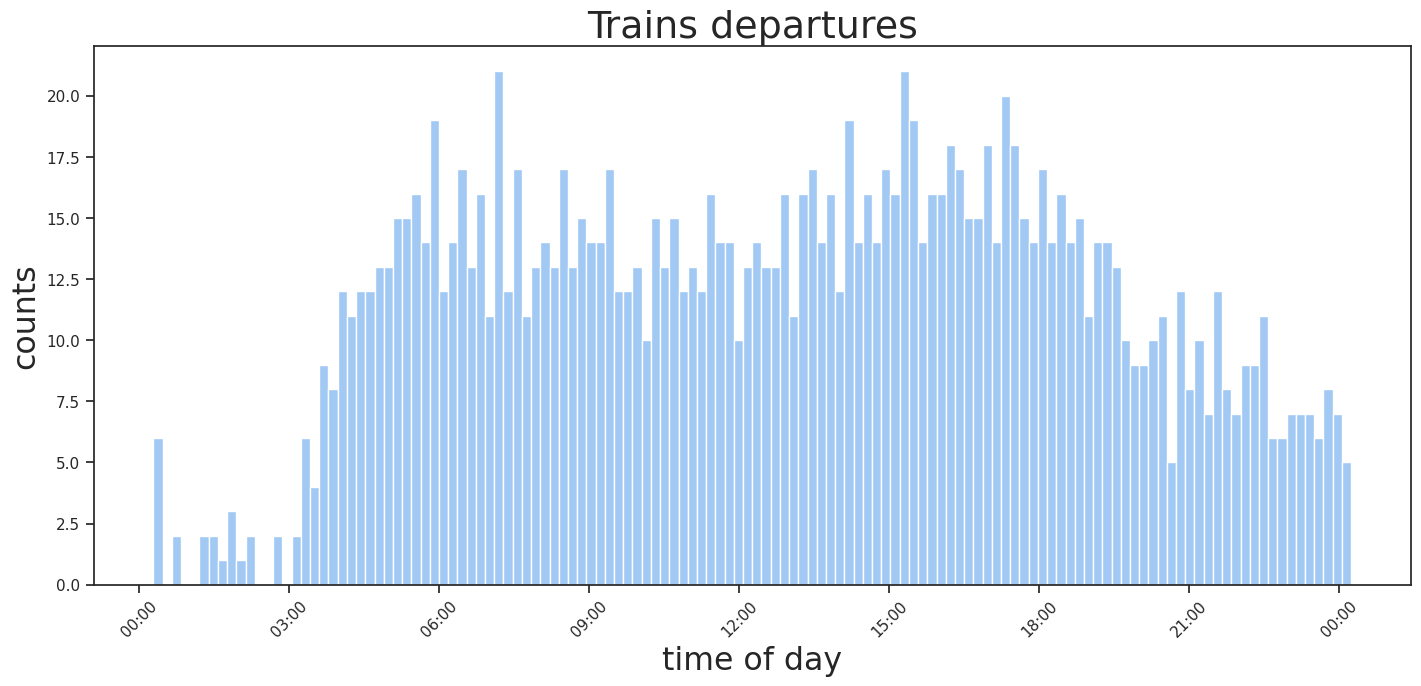

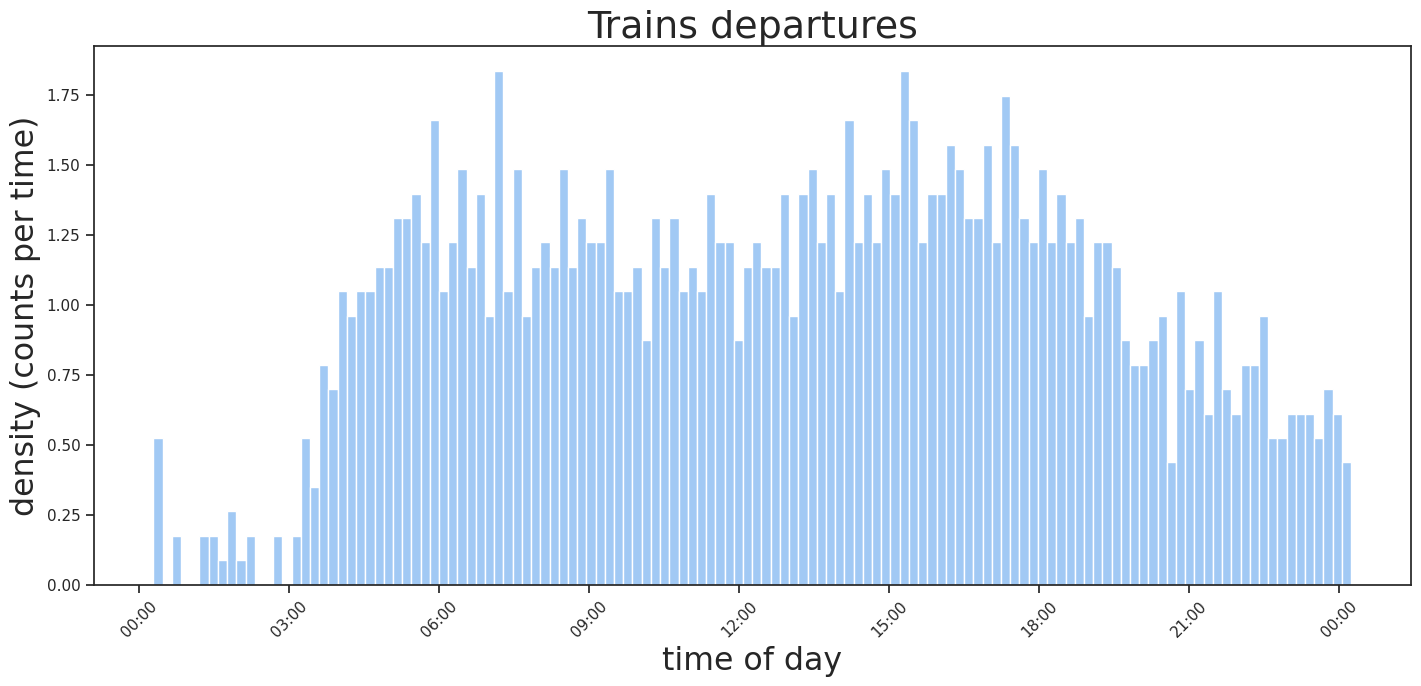

In [109]:
df.hist(column='dateTime', bins=130)

plt.gca().set_title('Trains departures')
plt.gca().set_xlabel('time of day') 
plt.gca().set_ylabel('counts')
format_date_xaxis()
plt.grid(False)

df.hist(column='dateTime', density = True, bins=130)
plt.gca().set_title('Trains departures')
plt.gca().set_xlabel('time of day') 
plt.gca().set_ylabel('density (counts per time)')
format_date_xaxis()
plt.grid(False)
plt.plot()
plt.gcf()
plt.show()

Oct 28 data: There are two rush hours, visible as bumps, one between 6am and 9am and the other between 3pm and 6pm. \
Nov 01 data: There are two rush hours, visible as bumps, one at around 6am and the other around 3-4pm.

### Where the most trains depart? (Departures, by platform)

In [110]:
print(f"Frankfurt(Main) ('U-Bahn' excluded) has a total of {df["platform"].nunique()} platforms in use, {df["platform"][df["platform"]<100].nunique()} overground and {df["platform"][df["platform"]>=100].nunique()} underground.")

Frankfurt(Main) ('U-Bahn' excluded) has a total of 28 platforms in use, 24 overground and 4 underground.


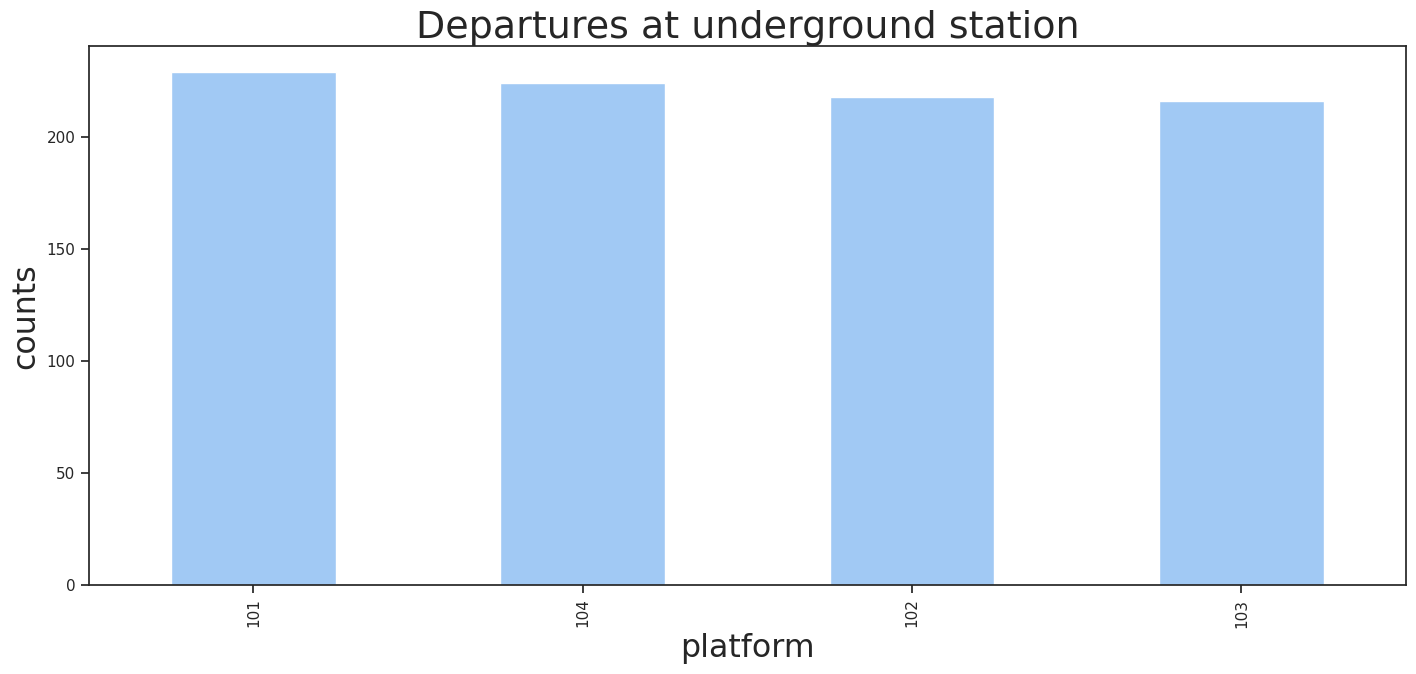

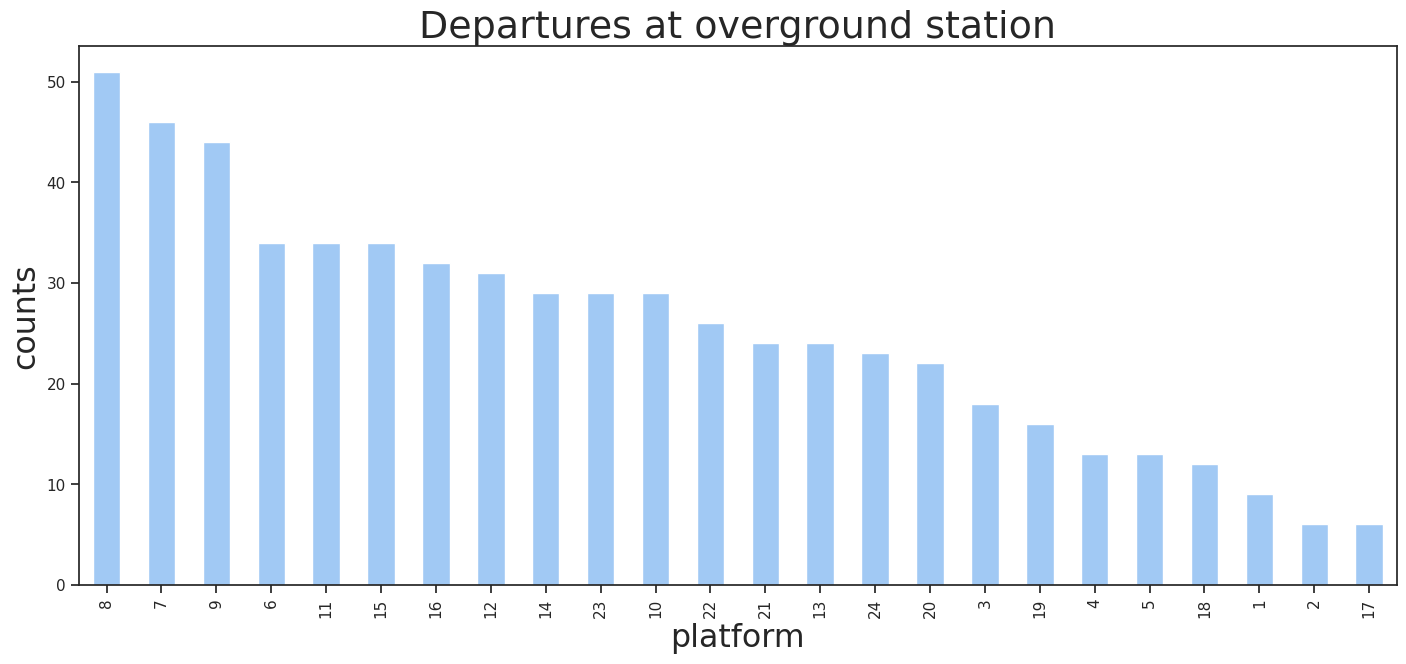

In [111]:
#plt.locator_params(axis='x', nbins=4)
def plot_platform_counts(series, sort_by_platform = False):
    plt.figure() #new plot
    val_counts = series.value_counts()
    if sort_by_platform: 
        val_counts = pd.Series.sort_index(series.value_counts())
    val_counts.plot.bar().set_ylabel('counts')
    #print(labels)
    plt.grid(False)
    plt.plot()
    
#f.loc(df["platform"]>=100, "platform" )
plot_platform_counts(df["platform"][df["platform"]>=100], False)
plt.gca().set_title('Departures at underground station')
# plot_platform_counts(df["platform"][df["platform"]>=100], True)
# plt.gca().set_title('Departures at underground station')
plot_platform_counts(df["platform"][df["platform"]<100], False)
plt.gca().set_title('Departures at overground station')
# plot_platform_counts(df["platform"][df["platform"]<100], True)
# plt.gca().set_title('Departures at overground station')

# uncomment above and scroll to see all four plots. 
plt.show()

For both Oct 28 and Nov 01 data: \
At underground, most trains depart from platform 101. \
At overground, most trains depart from platform 8.

### When in the day are the most trains cancelled?

In [112]:
cancelled = df[df['cancelled']] # boolean mask
print(f"{len(cancelled)} of {len(df)} where cancelled")
print("The cancelled trains are:")
print(cancelled.reset_index()[["name","dateTime"]])

4 of 1492 where cancelled
The cancelled trains are:
       name                  dateTime
0  HLB15032 2024-10-28 21:51:00+01:00
1  HLB15132 2024-10-28 21:51:00+01:00
2  HLB15034 2024-10-28 22:31:00+01:00
3  HLB15134 2024-10-28 22:31:00+01:00


Oct 27 data: All cancellations are regional trains. \
Nov 01 data: Most cancellations are regional trains, with the exception of one intercity train.

### What does the delay distribution look like, and how do delay times and cancelations of different train types (intercity trains, regional traffic and suburban trains) compare?

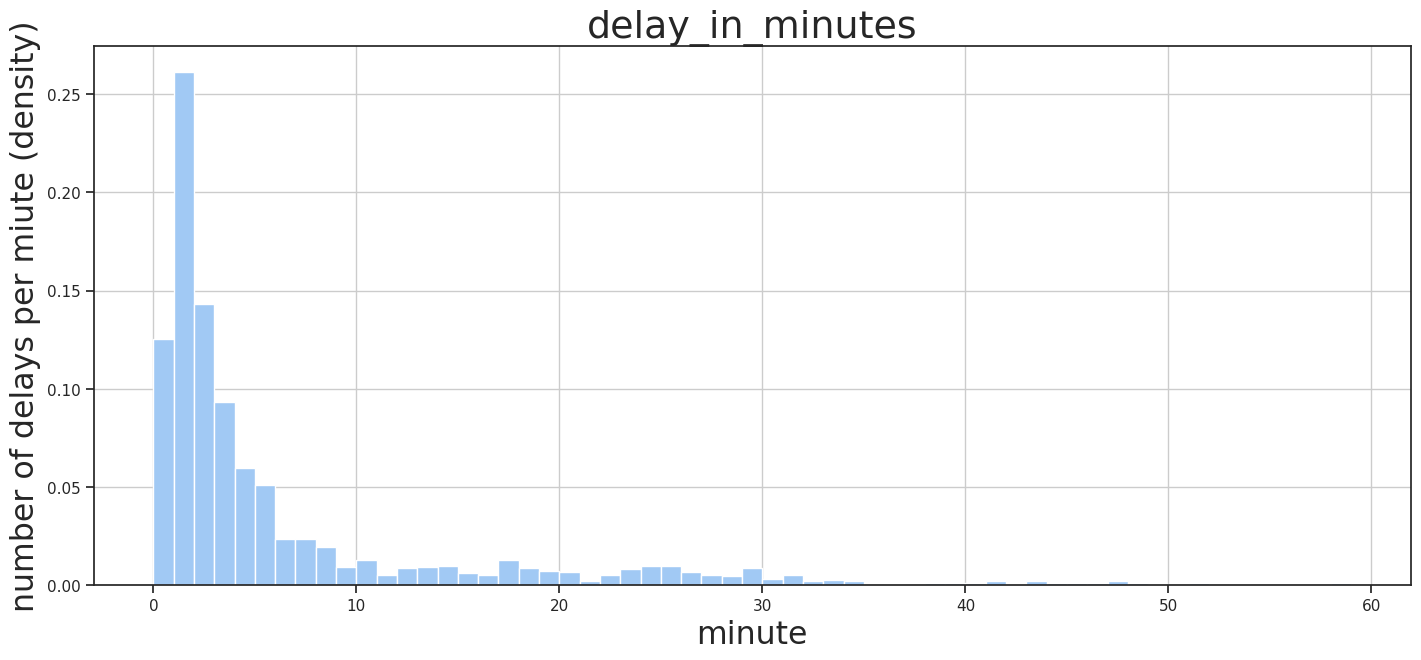

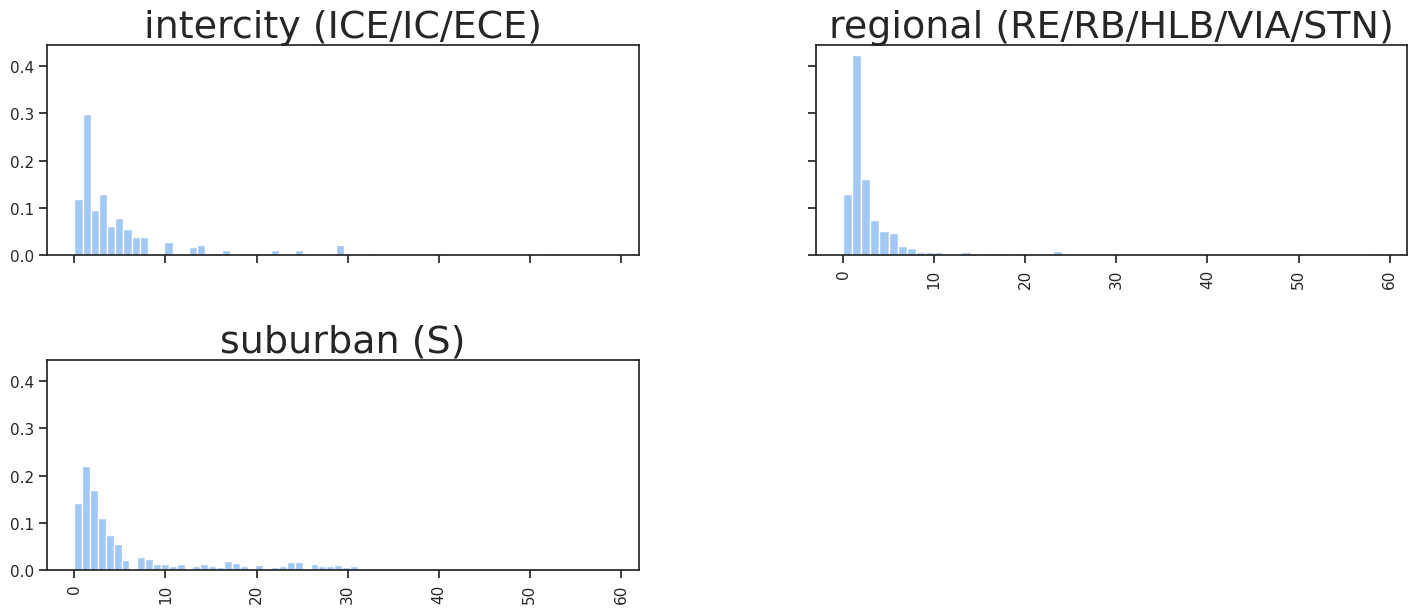

In [113]:
df['delay_in_minutes'] = (df['delay'].astype('timedelta64[s]')/60).fillna(np.timedelta64(0)).astype('int64')
df['type'] = df['name'].replace('(\\d|\\s)', '', regex=True) #remove all numbers and whitespaces
#print(df["type"].value_counts())
train_category = {"ICE": "intercity (ICE/IC/ECE)", 
                  "IC": "intercity (ICE/IC/ECE)",
                  "ECE": "intercity (ICE/IC/ECE)",
                  "RE": "regional (RE/RB/HLB/VIA/STN)",
                  "RB": "regional (RE/RB/HLB/VIA/STN)",
                  "HLB": "regional (RE/RB/HLB/VIA/STN)",
                  "VIA": "regional (RE/RB/HLB/VIA/STN)",
                  "STN": "regional (RE/RB/HLB/VIA/STN)",
                  "S": "suburban (S)"
                 }
df['type']=df['type'].map(train_category)


df.hist(column='delay_in_minutes', density=True,  bins = df['delay_in_minutes'].max())
# plt.axvline(df['delay_in_minutes'].median(), color='r', linewidth=.5)
plt.gca().set_xlabel('minute') 
plt.gca().set_ylabel('number of delays per miute (density)')
plt.show()

df.hist(column='delay_in_minutes', by='type', sharex=True,sharey=True, density=True, bins = df['delay_in_minutes'].max())
# plt.axvline(df['delay_in_minutes'].median(), color='r', linewidth=.8)
plt.gca().set_xlabel('minute') 
plt.gca().set_ylabel('number of delays per minute (density)')
#df['delay'].iloc[1].as_unit('s')
#df['delay'].as_unit('s').hist( bins=130)
plt.show()

All of the train types behave similarly in their delay times, as in they all resemble a lognormal distribution. \ 
Whether it is truly lognormally distributed can be checked by comparing the data with a lognormal pdf (probablitiy density function) fit.

## What is the probability that trains after a delayed train are also delayed?

In [114]:
is_next_late = (df.iloc[row+1]['delay'] > np.timedelta64(0) for row in range(len(df.index)-1))
is_next_late_array = np.fromiter(is_next_late,bool)

print("probability train is delayed given last train was delayed:", is_next_late_array[(df['delay'] > np.timedelta64(0))[:-1]].mean())
print("probability train is delayed given last train was not delayed:", is_next_late_array[(df['delay'] == np.timedelta64(0))[:-1]].mean())

probability train is delayed given last train was delayed: 0.9149425287356322
probability train is delayed given last train was not delayed: 0.7007299270072993


### The last train is not special, so lets consider the last n trains, for a given n

In [115]:
window_size = 30 #n

In [116]:
# with custom generator
def window_next_n(data, n = window_size):
    for start_row in range(len(data.index)):
        end_row  = min(start_row + window_size, len(data.index))
        yield data.iloc[start_row:end_row, :]
        

#print(df)
frequency_next_trains_are_late =((window['delay'] > np.timedelta64(0)).mean() for window in window_next_n(df))
number_of_delay_in_next_n_trains = np.fromiter(frequency_next_trains_are_late, float)
print(f"probability delayed given delay in last {window_size} trains:", number_of_delay_in_next_n_trains[df['delay'] > np.timedelta64(0)].mean())
print(f"probability on time given no delay in last {window_size} trains:", number_of_delay_in_next_n_trains[df['delay'] == np.timedelta64(0)].mean())

#print(pd.Series((_ for _ in (get_chunk)['delay'] > np.timedelta64(0)).sum()))

probability delayed given delay in last 30 trains: 0.9105491698595147
probability on time given no delay in last 30 trains: 0.6734793187347932


In [117]:
# with rolling and shift; about 1000x faster
number_of_delay_in_next_n_trains = (df['delay'] > np.timedelta64(0)).shift(-window_size).rolling(window_size, min_periods=1).sum()

print(f"probability delayed given delay in last {window_size} trains:", number_of_delay_in_next_n_trains[df['delay'] > np.timedelta64(0)].mean()/window_size)
print(f"probability on time given no delay in last {window_size} trains:", number_of_delay_in_next_n_trains[df['delay'] == np.timedelta64(0)].mean()/window_size)


probability delayed given delay in last 30 trains: 0.9028607918263091
probability on time given no delay in last 30 trains: 0.6717761557177616


###  How is delay related to the train density?

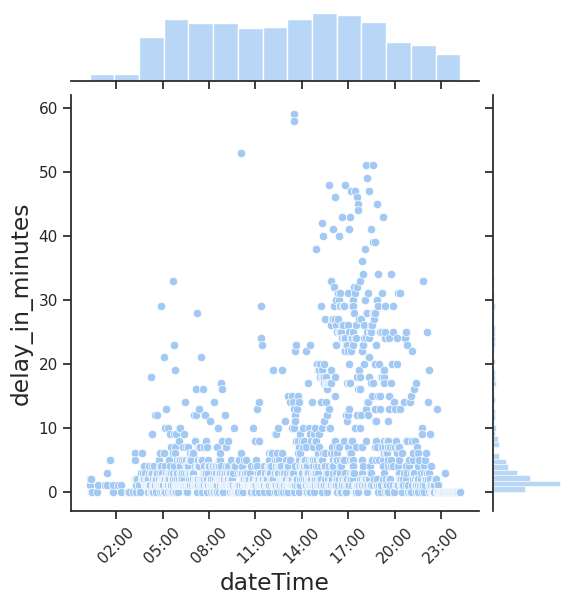

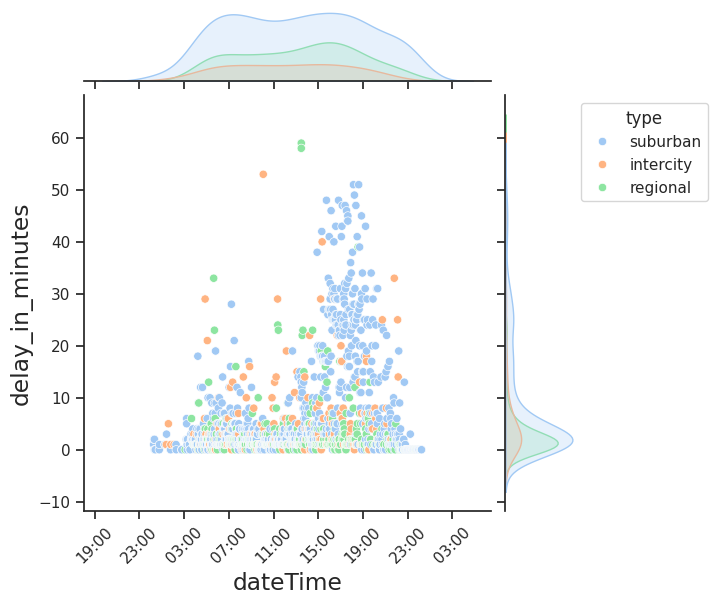

In [118]:
import seaborn as sns
rcParams["font.size"] = seaborn_fontsize

train_category_rename = {"intercity (ICE/IC/ECE)": "intercity", 
                  "regional (RE/RB/HLB/VIA/STN)": "regional",
                  "suburban (S)": "suburban"
                 }
df['type_short']=df['type'].map(train_category_rename)

g = sns.jointplot(data=df, x="dateTime", y="delay_in_minutes")
format_date_xaxis()
g.savefig("figures/comparison_delay_density.pdf") 
#plt.show()

g = sns.jointplot(data=df, x="dateTime", y="delay_in_minutes", hue="type_short") #linewidth=0.2, alpha = 0.8
#sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(.55, .45), title='Species')
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.2, 1), title='type')
#ax.ax_joint.legend(bbox_to_anchor=(1.5, 1.1))
format_date_xaxis()
#plt.savefig("--.pdf")

g.savefig("figures/comparison_delay_density_types.pdf") 
plt.show()
#plot hat sides are: kernel density estimate (KDE) plots



In [119]:
g = sns.jointplot(data=df, x="dateTime", y="delay_in_minutes", hue="type_short", marginal_kws={'common_norm':False}) #linewidth=0.2, alpha = 0.8
#sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(.55, .45), title='Species')
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.2, 1), title='type')
#ax.ax_joint.legend(bbox_to_anchor=(1.5, 1.1))
format_date_xaxis()
#plt.savefig(".pdf")

In [120]:
g = sns.jointplot(data=df, x="dateTime", y="delay_in_minutes", hue="type_short", kind="kde",marginal_kws={'common_norm':False}) #linewidth=0.2, alpha = 0.8
#sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(.55, .45), title='Species')
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1.2, 1), title='type')
#ax.ax_joint.legend(bbox_to_anchor=(1.5, 1.1))
format_date_xaxis()
g.savefig("figures/comparison_delay_density_types_all.pdf") 
#plt.savefig(".pdf")

In [121]:
plots = []
for type in {"regional", "intercity", "suburban"}:
    g = sns.jointplot(data=df[df["type_short"] == type], x="dateTime", y="delay_in_minutes", kind="kde") #linewidth=0.2, alpha = 0.8
    format_date_xaxis()
    g.fig.suptitle(type, fontsize=12)
    g.savefig(f"figures/comparison_delay_density_{type}.pdf") 
    plots.append(g.fig)
    plt.close(g.fig)
     

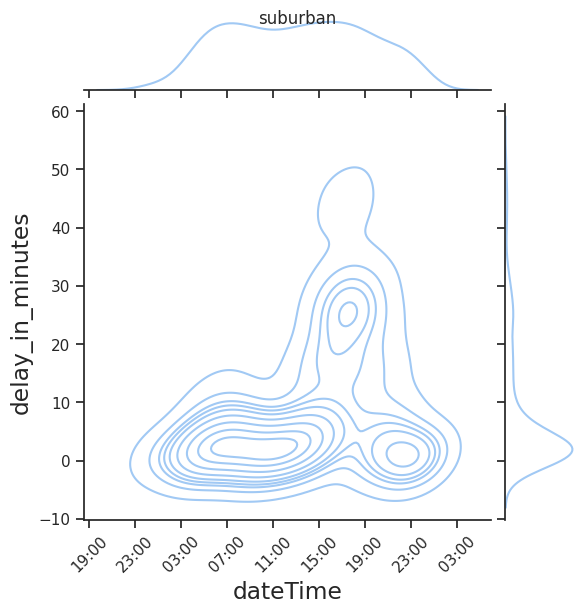

In [122]:
display(plots[0])

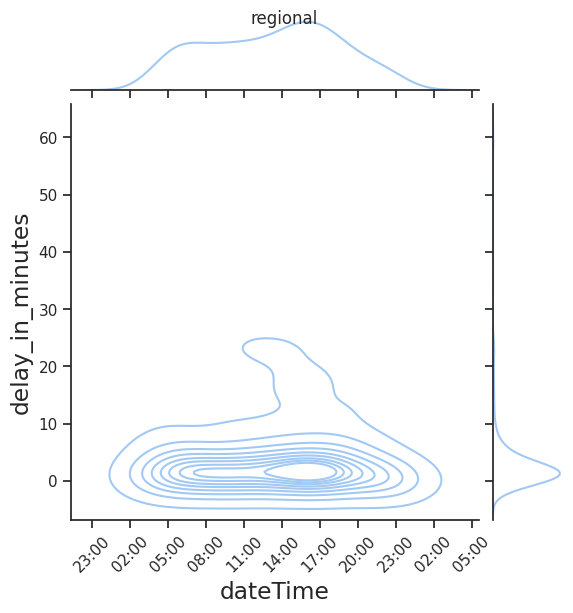

In [123]:
display(plots[1])

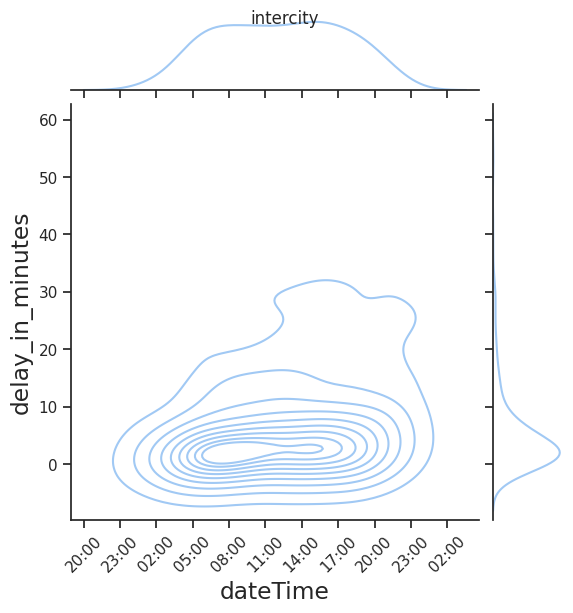

In [124]:
display(plots[2])

The horizontal plot displays the train distribution over time, 
while the vertical plot displays the delaytime distribution. \
From the suburban scatter plot, we recognize the trend where most delays are 1-2 hours behind the rush hours: \
the scatter plot peaks at 6-7am and 6-7pm, while the train distribution peaks at 6am and 4pm. \
As for the delay amount, there is no clear proportionality. While the peaks of train distribution are similarly high, the peaks of the delays are very different from each other.

## Everything in one: Pairplots

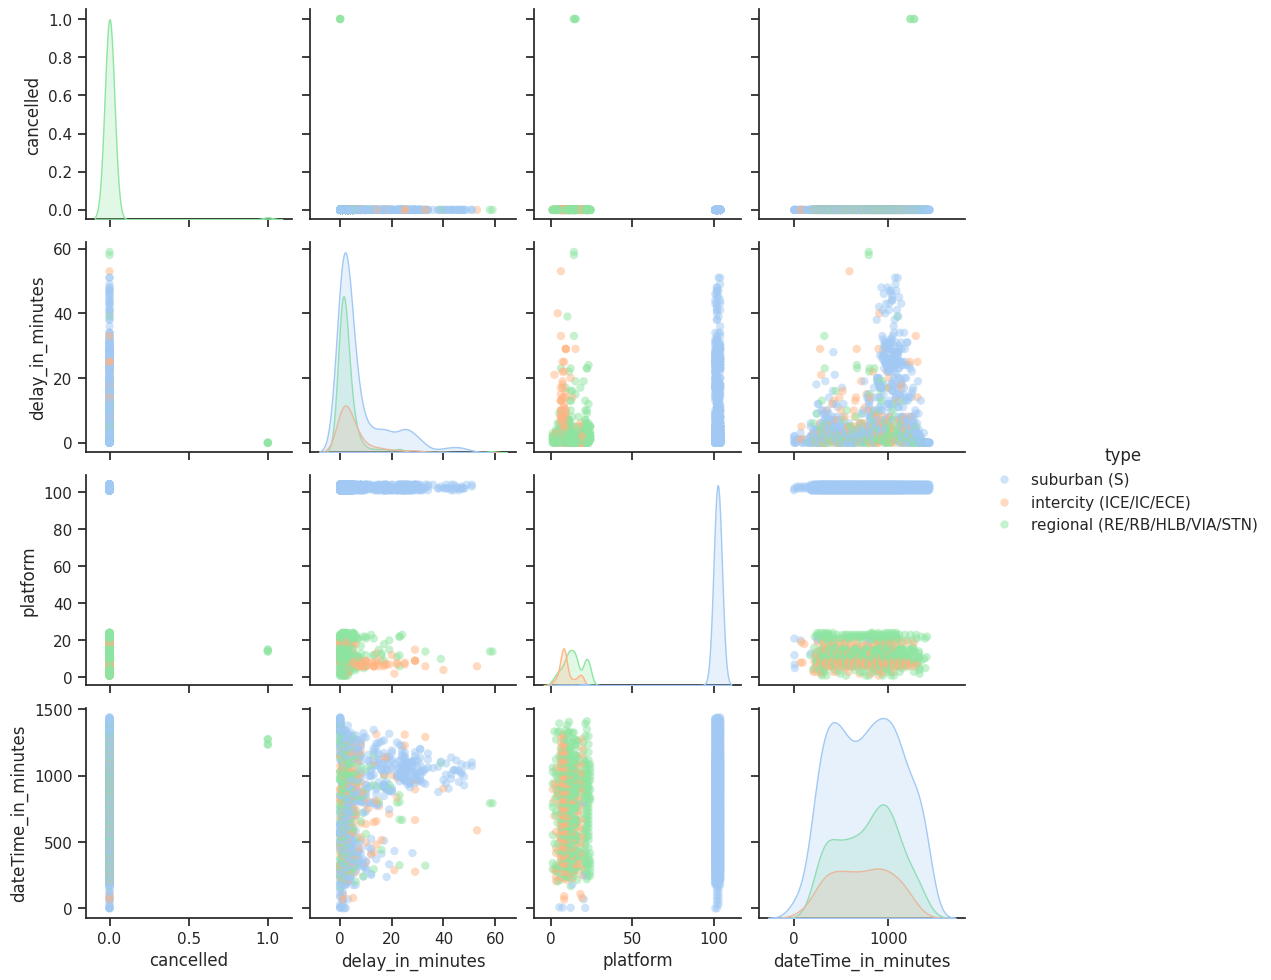

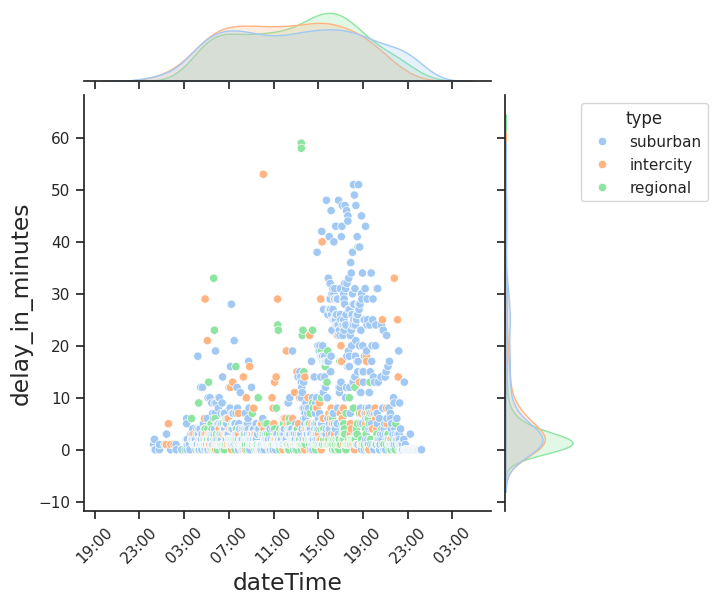

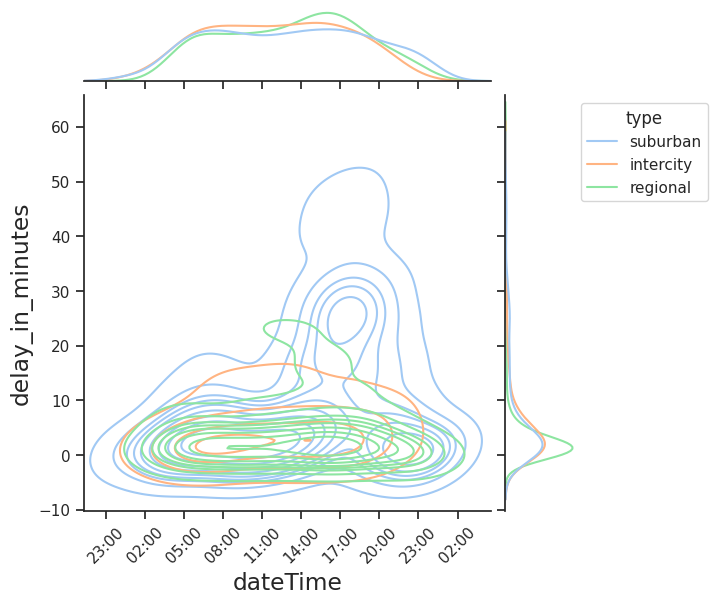

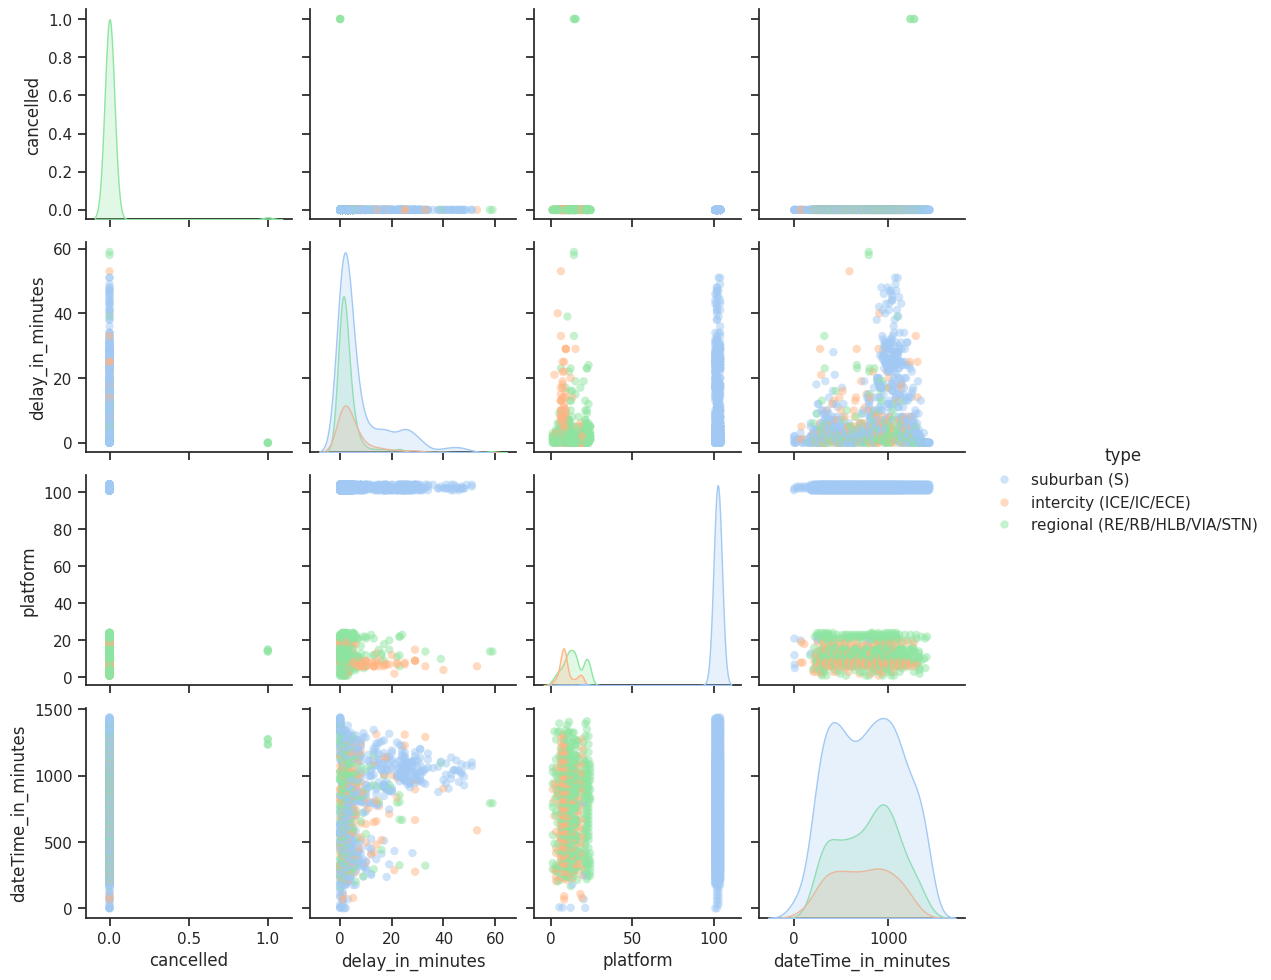

In [125]:
rcParams.update(rcParamsDefault)
sns.set_theme(style="ticks", palette="pastel")
rcParams["font.size"] = seaborn_fontsize
interesting_data = df[["dateTime","cancelled","delay_in_minutes","platform","type"]].copy()
interesting_data['dateTime_in_minutes'] = (interesting_data['dateTime'] - interesting_data['dateTime'].iloc[0]).dt.total_seconds() / 60
#dateTime_in_minutes (after start)
g = sns.pairplot(interesting_data, hue='type', plot_kws=dict(linewidth = 0.0, alpha= 0.5))#kind="hist"
#g.map_lower(sns.kdeplot)
g.savefig("figures/pairplots.pdf")
display(g.fig)
plt.show()

## Optional statistical analysis: Fitting of probability denstiy functions

If the delaytime $X$ is a lognormally distributed value, then the probability density function (pdf) $p_X$ will be \
$$
    p_X = \frac{1}{x \sqrt{2 \pi \sigma^2}} \exp\left(- \frac{1}{2}\frac{\left( \ln{x} - \mu \right)^2}{\sigma^2} \right) ,
$$
with $\mu$ the mean and $\sigma^2$ the variance of $\ln{(X)}$. As a reference, see \
https://en.wikipedia.org/wiki/Log-normal_distribution \
The idea now is to calculate $\mu$ and $\sigma$ from the dataset and see if these parameters produce the same lognormal pdf as the data suggests in its histogram plot. If it does, it means that the delaytime was lognormal distributed. \
If $X$ is the delaytime and $Y = \ln{X}$ its natural logarithm, we can then calculate our parameters using the table below: 
| Variable | mean $\mu$ | median $\text{med}$ | variance $\sigma^2$ |
| --- | --- | --- | --- |
| $X$ | $\mu_X = \exp\left( \mu + \frac{\sigma^2}{2} \right)$| $\text{med}_{X} = \exp(\mu)$ | $\sigma^2_{X} = \exp(2\mu + 2\sigma^2) - \exp(2\mu + \sigma^2)$ |
| $Y$ | $\mu = \ln(\text{med}_X)$| $\text{med} = \mu$ | $\sigma^2 = \ln(\mu_X) - \ln(\text{med}_X)$ |

$\mu_X$, $\text{med}_X$ and $\sigma^2_X$ can be determined with the built-in functions $\texttt{.mean()}, \texttt{.median()}$ and $\texttt{.var()}$ of the data column.

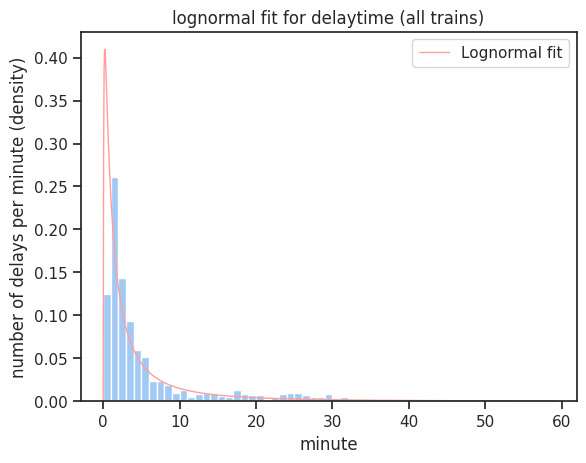

all trains:  mu = 0.6931471805599453; var = 2.264446720535129


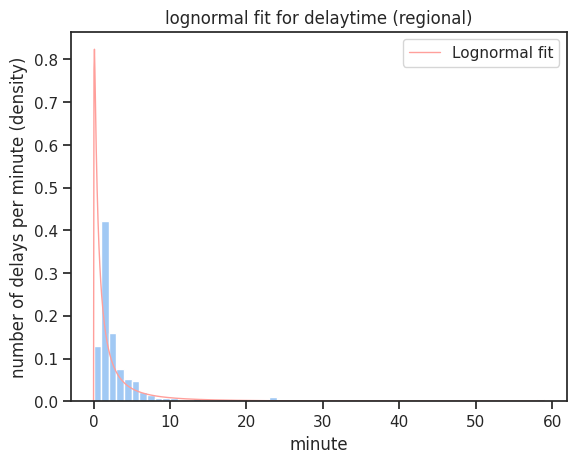

regional (RE/RB/HLB/VIA/STN):  mu = 0.0; var = 2.2883795943288576


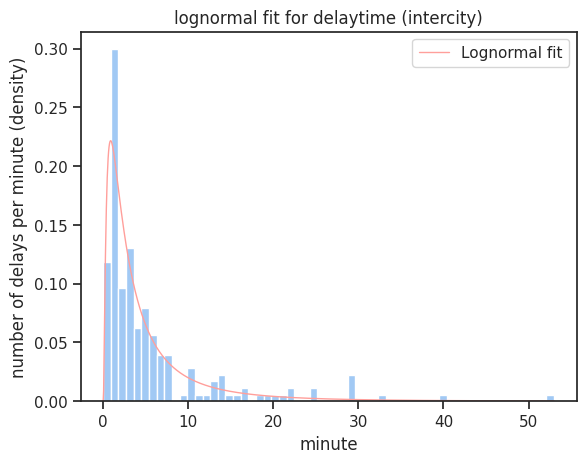

intercity (ICE/IC/ECE):  mu = 1.0986122886681096; var = 1.226067936853945


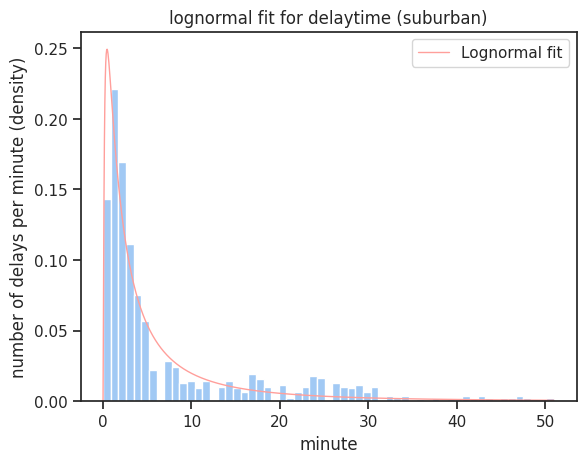

suburban (S):  mu = 1.0986122886681096; var = 1.897296867393087


In [126]:
# lognormal pdf fit 
def logn(x,mu,var):
    return np.divide(1,x*np.sqrt(2*var*np.pi)) * np.exp(-np.divide(np.power(np.log(x)-mu,2),2*var))


def logfit(specific, traintype, simplename):
    # picking the data: all traintypes or a specific one?
    if specific == True:
        data = df.loc[df['type'] == traintype, 'delay_in_minutes']
    else: 
        data = df['delay_in_minutes']

    # parameters for lognormal fit
    mu = np.log(data.median()) # mean of ln(X)
    var = 2*( np.log(data.mean()) - np.log(data.median()) ) # variance of ln(X), "sigma squared"
    
    # data histogram + lognormal fit
    data.hist(density=True,  bins = df['delay_in_minutes'].max())
    plt.gca().set_xlabel('minute') 
    plt.gca().set_ylabel('number of delays per minute (density)')
    plt.title(f"lognormal fit for delaytime ({simplename})")

    x = np.linspace(1e-9, data.max(), 1000)
    plt.plot(x, logn(x,mu,var), 'r', linewidth=1, label='Lognormal fit')
    plt.legend()
    plt.grid(False)
    plt.show()
    print(f"{traintype}:  mu = {mu}; var = {var}")
    plt.savefig(f"figures/lognormal_fit_{simplename}.pdf")

logfit(False, 'all trains', "all trains")
logfit(True, 'regional (RE/RB/HLB/VIA/STN)', "regional")
logfit(True, 'intercity (ICE/IC/ECE)', "intercity")
logfit(True, 'suburban (S)', "suburban")

both Oct 28 and Nov 01 data: \
We can see that the parameters we calculated with the data do not produce the exact same pdf as the data, as the maximum of the fitted pdf is significantly higher than the maximum value of our dataplot (except intercity). Besides the maximum, the tail of the pdf seems to align to the data with the exception of suburban, whose fitted tail goes much faster to zero than the data. \
This would mean that either a) the delaytime is not lognormally distributed at all or b) the delaytimes had outliers on that day. \
